<a href="https://colab.research.google.com/github/EytanTsytkin/DataScienceShorts/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, lars_path

pd.options.mode.chained_assignment = None
sns.set_style("whitegrid")

# **Overview and Feature Extraction**

In [ ]:
data = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# test['Survived'] = [np.nan for x in range(test.shape[0])]
# data = pd.concat([data,test])
data.set_index('PassengerId', inplace=True)

In [ ]:
data.shape

(891, 11)

In [ ]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Lets Explore each discrete features' correlation to survival:
data.pivot_table(index='Pclass',values='Survived').reset_index()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [ ]:
# Pclass seems to have negative correlation with survival - we should keep it.
p_data = pd.get_dummies(data['Pclass'],prefix='Pclass')
data = data.join(p_data)

In [ ]:
data.pivot_table(index="Sex",values='Survived').reset_index()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [ ]:
# Sex is clearly related to survival.
# Lets dummy it:

In [ ]:
sex_data = pd.get_dummies(data['Sex'],prefix='is')
print(sex_data.shape)
data = data.join(sex_data)
data.shape

(891, 2)


(891, 16)

In [ ]:
data.pivot_table(index='SibSp',values='Survived').reset_index()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [ ]:
# The distribution seems exponential/poisson.
# Lets split this column to dummies:
data['SibSpTemp'] = data['SibSp']
data['SibSpTemp'].replace(5,'5_Plus',inplace=True)
data['SibSpTemp'].replace(8,'5_Plus',inplace=True)
sibsp_data = pd.get_dummies(data['SibSpTemp'],prefix='SibSp')
data = data.join(sibsp_data)
data.drop('SibSpTemp',axis=1,inplace=True)
data.shape

(891, 22)

In [ ]:
# Lets check if SibSp + Parch is correlated to survival, with addition to sex.
data['Sex'] = [-1 if x == 'male' else 1 for x in data['Sex'].values]
data['Family_Size'] = data['SibSp'] + data['Parch']
data.pivot_table(index='Family_Size',values='Survived').reset_index()

,Family_Size,Survived
0,0,0.303538
1,1,0.552795
2,2,0.578431
3,3,0.724138
4,4,0.200000
5,5,0.136364
6,6,0.333333
7,7,0.000000
8,10,0.000000


In [ ]:
# Not too different from SibSp, but can be encoded to dummies.
# Lets Check correlation to sex:
data['Family_Size_Sex'] = data['Family_Size'] * data['Sex']
data.pivot_table(index='Family_Size_Sex',values='Survived').reset_index()

,Family_Size_Sex,Survived
0,-10,0.000000
1,-7,0.000000
2,-6,0.250000
3,-5,0.000000
4,-4,0.000000
5,-3,0.500000
6,-2,0.396226
7,-1,0.243243
8,0,0.303538
9,1,0.816092


In [ ]:
# Seems informative, lets encode it to dummies!
fam_data = pd.get_dummies(data['Family_Size_Sex'],prefix='FSS')
data = data.join(fam_data)
data.drop(['Sex','Family_Size','Family_Size_Sex','SibSp'],axis=1,inplace=True)
data.shape

(891, 37)

In [ ]:
data.pivot_table(index='Parch',values='Survived').reset_index()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [ ]:
par_data = pd.get_dummies(data['Parch'],prefix='Parch')
data = data.join(par_data)

In [ ]:
data.pivot_table(index='Embarked',values='Survived').reset_index()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [ ]:
# Embarked also has a negative correlation to survival.
# Let's dummy it:
emb_data = pd.get_dummies(data['Embarked'],prefix='Embarked')
data = data.join(emb_data)
data.shape

(891, 47)

In [ ]:
# Cabin is also discrete, but different
data.Cabin.describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [ ]:
data.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [ ]:
# We assume that the floor on the cabin is represented by the letter (usual human encoding).
# Lets look for corrolation between survival and cabin floorr:

In [ ]:
data['CabinFloor'] =  data['Cabin'][~data['Cabin'].isna()].apply(lambda x: x[0])

In [ ]:
data.pivot_table(index='CabinFloor',values='Survived').reset_index()

,CabinFloor,Survived
0,A,0.466667
1,B,0.744681
2,C,0.593220
3,D,0.757576
4,E,0.750000
5,F,0.615385
6,G,0.500000
7,T,0.000000


In [ ]:
data['CabinFloor'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: CabinFloor, dtype: int64

In [ ]:
# The significant measures (A-E) seems to be exact (not outliers).
# Since the correlation is not uniform, let's encode cabin floor to dummies:
floor_data = pd.get_dummies(data['CabinFloor'],prefix='Floor')
data = data.join(floor_data)
data.drop(['Floor_G','Floor_T'],axis=1,inplace=True)
data.head(2)

,Survived,Pclass,Name,Age,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,...,Embarked_C,Embarked_Q,Embarked_S,CabinFloor,Floor_A,Floor_B,Floor_C,Floor_D,Floor_E,Floor_F
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,0,A/5 21171,7.2500,NaN,S,0,...,0,0,1,NaN,0,0,0,0,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,0,PC 17599,71.2833,C85,C,1,...,1,0,0,C,0,0,1,0,0,0


In [ ]:
# In ships, the odd numbered cabins are on the starboard, 
# While the even numbered ones are port side.
# We can create another feature off this:

data['isStarboard'] =  data['Cabin'][~data['Cabin'].isna()].apply(lambda x: 'PortSide' if x[-1].isnumeric() and int(x[-1]) % 2 == 0 else 'Starborad')
data['isStarboard'].fillna('Neither',inplace=True)
data.pivot_table(index='isStarboard',values='Survived').reset_index()

,isStarboard,Survived
0,Neither,0.299854
1,PortSide,0.618182
2,Starborad,0.723404


In [ ]:
# Lets encode it dummies:
star_data = pd.get_dummies(data['isStarboard'],prefix='CabinSide')
data = data.join(star_data)

In [ ]:
# Let's check the relation between fare and survival:
data.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [ ]:
# Looking for outliers
print(data['Fare'][data['Fare']>100].count())
print(data['Fare'][data['Fare']>200].count())
print(data['Fare'][data['Fare']>250].count())
print(data['Fare'][data['Fare']>300].count())
# Let's cut the fare > 300.

53
20
9
3


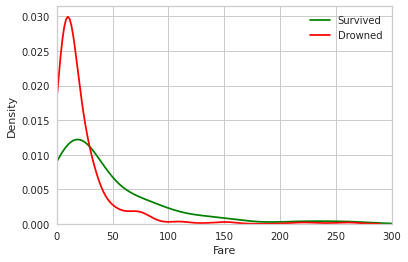

In [ ]:
sns.kdeplot(data['Fare'][data["Survived"].eq(1)], color="green")
sns.kdeplot(data['Fare'][data["Survived"].eq(0)], color="red")
plt.legend(['Survived', 'Drowned'])
plt.xlim(0, 300)
plt.show()

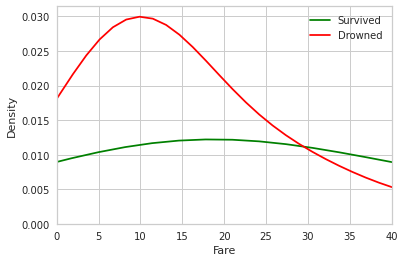

In [ ]:
# Zooming In:
sns.kdeplot(data['Fare'][data["Survived"].eq(1)], color="green")
sns.kdeplot(data['Fare'][data["Survived"].eq(0)], color="red")
plt.legend(['Survived', 'Drowned'])
plt.xlim(0, 40)
plt.show()

In [ ]:
# Let's bucket the fare into ranges: 0, 0-20, 20-30, 30-70, 70_plus

def FareBucket(x):
  if x == 0:
    return 'No Fare'
  if x < 20:
    return "0-20"
  if 20 <= x < 30:
    return "20-30"
  if 30 <= x < 70:
    return "30-70"
  if 70 <= x:
    return "70_plus"

data['FareBucket'] = data['Fare'].apply(lambda x: FareBucket(x))
data.pivot_table(index='FareBucket',values='Survived').reset_index()

,FareBucket,Survived
0,0-20,0.284000
1,20-30,0.426471
2,30-70,0.481481
3,70_plus,0.723810
4,No Fare,0.066667


In [ ]:
# 20-30 and 30-70 are quiet similar, lets merge them.

def FareBucket(x):
  if x == 0:
    return 'No Fare'
  if 0< x < 20:
    return 'LowFare'
  if 20 <= x < 70:
    return 'MedFare'
  if 70 <= x:
    return 'HighFare'

data['FareBucket'] = data['Fare'].apply(lambda x: FareBucket(x))
data.pivot_table(index='FareBucket',values='Survived').reset_index()

,FareBucket,Survived
0,HighFare,0.723810
1,LowFare,0.284000
2,MedFare,0.453875
3,No Fare,0.066667


In [ ]:
# Dummify:
fare_data = pd.get_dummies(data['FareBucket'],prefix='ticket')
data = data.join(fare_data)
data.drop('Fare',axis=1,inplace=True)
data.shape

(891, 62)

In [ ]:
# Let's check the connection between embarked and fare_bucket:
data['FareEmbark'] = data['FareBucket'] + '_' + data['Embarked']
data.pivot_table(index='FareEmbark',values='Survived').reset_index()

,FareEmbark,Survived
0,HighFare_C,0.780000
1,HighFare_Q,0.500000
2,HighFare_S,0.666667
3,LowFare_C,0.385714
4,LowFare_Q,0.400000
5,LowFare_S,0.243836
6,MedFare_C,0.562500
7,MedFare_Q,0.300000
8,MedFare_S,0.436620
9,No Fare_S,0.066667


In [ ]:
# Let's dummify and keep it:
frem_data = pd.get_dummies(data['FareEmbark'],prefix='Ticket')
data = data.join(frem_data)
data.drop('FareEmbark',axis=1,inplace=True)
data.shape

(891, 72)

In [ ]:
# Let's explore age:

In [ ]:
# Let's check the relation between fare and survival:
data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [ ]:
# Let's fill age's NA using names - 
# the average age for each name prefix should be enough.
data['Prefix'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].replace(" ",""))
print('Prefix na count: ', data['Prefix'].isna().sum(),end = '\n\n')
prefixMeanAge = data['Age'].groupby(data['Prefix']).agg(np.mean)
prefixMeanAge

Prefix na count:  0



Prefix
Capt           70.000000
Col            58.000000
Don            40.000000
Dr             42.000000
Jonkheer       38.000000
Lady           48.000000
Major          48.500000
Master          4.574167
Miss           21.773973
Mlle           24.000000
Mme            24.000000
Mr             32.368090
Mrs            35.898148
Ms             28.000000
Rev            43.166667
Sir            49.000000
theCountess    33.000000
Name: Age, dtype: float64

In [ ]:
# Find na indices:
naIdx = data.index[data['Age'].isna()]
naIdx
naAges = [prefixMeanAge[data['Prefix'][data.index == row ]] for row in naIdx]
data['Age'][data['Age'].isna()] =  naAges
data.Age.isna().sum()

0

In [ ]:
# Looking for outliers
print(data['Age'][data['Age']>40].count())
print(data['Age'][data['Age']>50].count())
print(data['Age'][data['Age']>60].count())
print(data['Age'][data['Age']>70].count())
# Let's cut above 70.

151
64
22
5


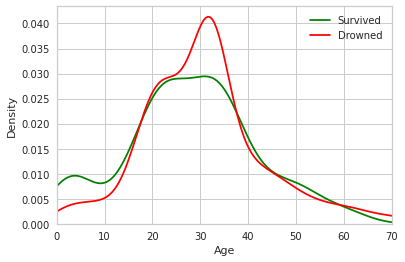

In [ ]:
sns.kdeplot(data['Age'][data["Survived"].eq(1)], color="green")
sns.kdeplot(data['Age'][data["Survived"].eq(0)], color="red")
plt.legend(['Survived', 'Drowned'])
plt.xlim(0, 70)
plt.show()

In [ ]:
# Between 0-15 the odds are in your favor,
# 15-24 odds are similar,
# 24 -36 odds are bad,
# 36-37 are similar,
# above 57 are bad.
# Let's bucket!

def AgeBucket(x):
  if x < 15:
    return 'Infant'
  if 15 <= x < 24:
    return 'Teen'
  if 24 <= x < 36:
    return 'Young Adult'
  if 36 <= x < 57:
    return 'Adult'
  if 57 <= x:
    return 'Eldery'


data['AgeBucket'] = data['Age'].apply(lambda x: AgeBucket(x))
data.pivot_table(index='AgeBucket',values='Survived').reset_index()

,AgeBucket,Survived
0,Adult,0.398907
1,Eldery,0.285714
2,Infant,0.573171
3,Teen,0.390244
4,Young Adult,0.341969


In [ ]:
# We are working with numerics, so we should encode it:
age_data = pd.get_dummies(data['AgeBucket'],prefix='is')
data = data.join(age_data)
data.drop('Age',axis=1,inplace=True)
data.shape

(891, 78)

In [ ]:
# Let's check prefix as a feature of it's own - it's basically sex + age:
data['Prefix'].value_counts()

Mr             517
Miss           182
Mrs            125
Master          40
Dr               7
Rev              6
Mlle             2
Major            2
Col              2
theCountess      1
Capt             1
Ms               1
Sir              1
Lady             1
Mme              1
Don              1
Jonkheer         1
Name: Prefix, dtype: int64

In [ ]:
# Let's map the prefixes

prefix_map = {
    "Mr":"Mr",            
    "Miss":"Miss",           
    "Mrs":"Mrs",           
    "Master":"Master",    
    "Dr": "Mr",                
    "Rev": "Mr",               
    "Mlle": "Miss",              
    "Major": "Mr",             
    "Col": "Mr",               
    "the Countess": "Mr",       
    "Capt": "Mr",              
    "Ms": "Mrs",                
    "Sir": "Mr",               
    "Lady": "Mrs",              
    "Mme": "Mrs",               
    "Don": "Mr",               
    "Jonkheer": "Mr",          
}

data['Prefix'] = data['Prefix'].apply(lambda x: prefix_map.get(x))
data['Prefix'].value_counts()

Mr        538
Miss      184
Mrs       128
Master     40
Name: Prefix, dtype: int64

In [ ]:
data.pivot_table(index='Prefix',values='Survived').reset_index()

,Prefix,Survived
0,Master,0.575000
1,Miss,0.701087
2,Mr,0.161710
3,Mrs,0.796875


In [ ]:
# Let's dummy it:
prefix_data = pd.get_dummies(data['Prefix'],prefix='Prefix')
data = data.join(prefix_data)
data.shape

(891, 82)

In [ ]:
# Let's check the connection between mean family age and survival:
data['LastName'] = data['Name'].apply(lambda x: x.split(' ')[0][:-1])
data['LastName'].value_counts()

Andersson    9
Sage         7
Goodwin      6
Johnson      6
Skoog        6
            ..
Fleming      1
Saalfeld     1
Hanna        1
Lewy         1
Dooley       1
Name: LastName, Length: 660, dtype: int64

In [ ]:
# Too much unique values - not worth including.
data.drop('LastName',axis=1,inplace=True)

In [ ]:
# Remove unneccecary columns:
data.drop([col for col in data.columns if data[col].dtype == 'object'],axis=1,inplace=True)
data.drop(['Parch','Pclass'],axis=1,inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 71 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Survived             891 non-null    int64
 1   Pclass_1             891 non-null    uint8
 2   Pclass_2             891 non-null    uint8
 3   Pclass_3             891 non-null    uint8
 4   is_female            891 non-null    uint8
 5   is_male              891 non-null    uint8
 6   SibSp_0              891 non-null    uint8
 7   SibSp_1              891 non-null    uint8
 8   SibSp_2              891 non-null    uint8
 9   SibSp_3              891 non-null    uint8
 10  SibSp_4              891 non-null    uint8
 11  SibSp_5_Plus         891 non-null    uint8
 12  FSS_-10              891 non-null    uint8
 13  FSS_-7               891 non-null    uint8
 14  FSS_-6               891 non-null    uint8
 15  FSS_-5               891 non-null    uint8
 16  FSS_-4               891 n

# **Correlation and PCA**

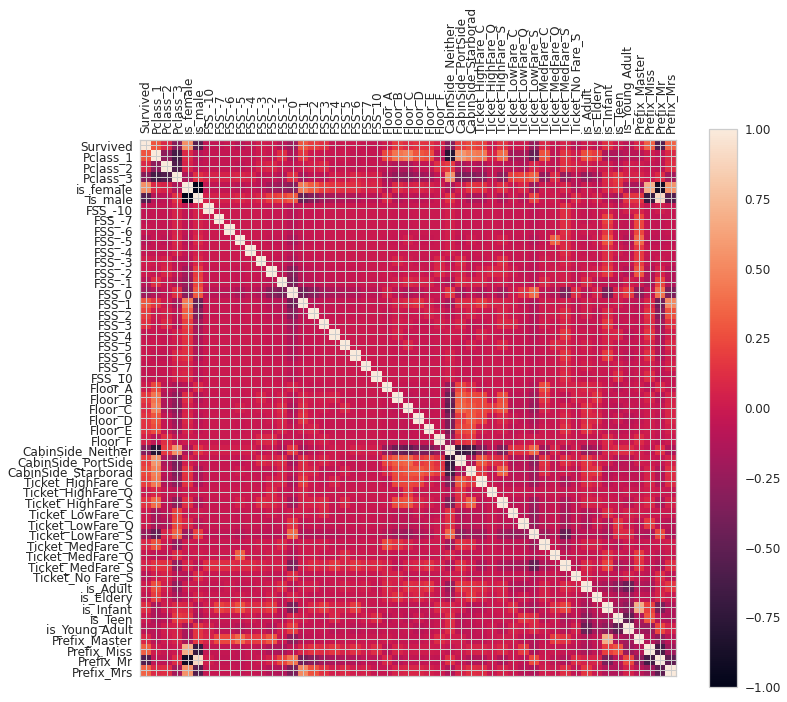

In [ ]:
for col in data.columns:
  if 'SibSp' in col or 'Parch' in col or 'Embarked' in col or 'ticket' in col:
    data.drop(col,axis=1,inplace=True)

# Correlation matrix:
f = plt.figure(figsize=(12, 10))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12, rotation=90)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

In [ ]:
# Lets use PCA to check how well can we explain the data so far:

In [ ]:
def prepare_for_pca(data): 
  numData = data.select_dtypes(include='number')
  numData.dropna(inplace=True)
  if 'Survived' in data.columns:
    Colors = numData['Survived']
    numData.drop('Survived',axis=1,inplace=True)
  if 'label' in data.columns:
    Colors = numData['label']
    numData.drop('label',axis=1,inplace=True)
  return numData, Colors

def make_pca_df(numData, ndim=2, scale=True):
  if scale:
    numData = MinMaxScaler().fit_transform(numData)
  pca = PCA(n_components=ndim)
  pc = pca.fit_transform(numData)
  pc_df = pd.DataFrame(data=pc, columns=[f"PC{n+1}" for n in range(ndim)]) 
  print('\n\nExplained variance via PCA:')             
  print(pca.explained_variance_ratio_,'\n\n\n')
  return pc_df

def make_pca_plot(data,title,ndim,scale=True):
  numData, Colors = prepare_for_pca(data)
  pc_df = make_pca_df(numData,ndim,scale)
  if 'bin_00_03' in numData.columns:
    plt.scatter(pc_df['PC1'], pc_df['PC2'], s=3, c=['b' if x == 1 else 'r' for x in Colors.values],label='Same user')
  else:
    plt.scatter(pc_df['PC1'], pc_df['PC2'], s=3, c=['b' if x == 1 else 'r' for x in Colors.values],label='Drowned')
  plt.title(f'PCA Plot - {title}')
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.legend()
  plt.show()



Explained variance via PCA:
[0.22552324 0.14897852 0.08061174 0.07772144 0.06655199] 





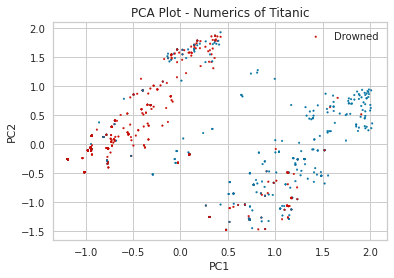

In [ ]:
make_pca_plot(data,"Numerics of Titanic",ndim=5,scale=False)

# **Model Training**

In [ ]:
def preprocess(data):
  data.set_index('PassengerId',inplace=True) 
  p_data = pd.get_dummies(data['Pclass'],prefix='Pclass')
  data = data.join(p_data)
  sex_data = pd.get_dummies(data['Sex'],prefix='is')
  data = data.join(sex_data)

  data['SibSpTemp'] = data['SibSp']
  data['SibSpTemp'].replace(5,'5_Plus',inplace=True)
  data['SibSpTemp'].replace(8,'5_Plus',inplace=True)
  sibsp_data = pd.get_dummies(data['SibSpTemp'],prefix='SibSp')
  data = data.join(sibsp_data)
  data.drop('SibSpTemp',axis=1,inplace=True)

  data['Sex'] = [-1 if x == 'male' else 1 for x in data['Sex'].values]
  data['Family_Size'] = data['SibSp'] + data['Parch']
  data['Family_Size_Sex'] = data['Family_Size'] * data['Sex']
  fam_data = pd.get_dummies(data['Family_Size_Sex'],prefix='FSS')
  data = data.join(fam_data)
  data.drop(['Sex','Family_Size','Family_Size_Sex','SibSp'],axis=1,inplace=True)

  par_data = pd.get_dummies(data['Parch'],prefix='Parch')
  data = data.join(par_data)
  # Adding Parch_9 to Train set:
  if 'Parch_9' not in data.columns:
    data['Parch_9'] = np.zeros(data.shape[0])

  emb_data = pd.get_dummies(data['Embarked'],prefix='Embarked')
  data = data.join(emb_data)

  data['CabinFloor'] =  data['Cabin'][~data['Cabin'].isna()].apply(lambda x: x[0])
  floor_data = pd.get_dummies(data['CabinFloor'],prefix='Floor')
  data = data.join(floor_data)
  if 'Floor_T' in data.columns:
    data.drop('Floor_T',axis=1,inplace=True)
  data.drop('Floor_G',axis=1,inplace=True)

  data['isStarboard'] =  data['Cabin'][~data['Cabin'].isna()].apply(lambda x: 'PortSide' if x[-1].isnumeric() and int(x[-1]) % 2 == 0 else 'Starborad')
  data['isStarboard'].fillna('Neither',inplace=True)
  star_data = pd.get_dummies(data['isStarboard'],prefix='CabinSide')
  data = data.join(star_data)

  def FareBucket(x):
    if x == 0:
      return 'No Fare'
    if 0< x < 20:
      return 'LowFare'
    if 20 <= x < 70:
      return 'MedFare'
    if 70 <= x:
      return 'HighFare'

  data['FareBucket'] = data['Fare'].apply(lambda x: FareBucket(x))
  fare_data = pd.get_dummies(data['FareBucket'],prefix='ticket')
  data = data.join(fare_data)
  # data.drop('Fare',axis=1,inplace=True)

  data['FareEmbark'] = data['FareBucket'] + '_' + data['Embarked']
  frem_data = pd.get_dummies(data['FareEmbark'],prefix='Ticket')
  data = data.join(frem_data)
  data.drop('FareEmbark',axis=1,inplace=True)

  data['Prefix'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].replace(" ",""))
  naIdx = data.index[data['Age'].isna()]
  naAges = [prefixMeanAge[data['Prefix'][data.index == row ]] for row in naIdx]
  data['Age'][data['Age'].isna()] =  naAges

  def AgeBucket(x):
    if x < 15:
      return 'Infant'
    if 15 <= x < 24:
      return 'Teen'
    if 24 <= x < 36:
      return 'Young Adult'
    if 36 <= x < 57:
      return 'Adult'
    if 57 <= x:
      return 'Eldery'


  data['AgeBucket'] = data['Age'].apply(lambda x: AgeBucket(x))
  age_data = pd.get_dummies(data['AgeBucket'],prefix='is')
  data = data.join(age_data)
  # data.drop('Age',axis=1,inplace=True)

  prefix_map = {
      "Mr":"Mr",            
      "Miss":"Miss",           
      "Mrs":"Mrs",           
      "Master":"Master",    
      "Dr": "Mr",                
      "Rev": "Mr",               
      "Mlle": "Miss",              
      "Major": "Mr",             
      "Col": "Mr",               
      "the Countess": "Mrs",       
      "Capt": "Mr",              
      "Ms": "Mrs",                
      "Sir": "Mr",               
      "Lady": "Mrs",              
      "Mme": "Mrs",               
      "Don": "Mr",               
      "Jonkheer": "Mr",          
  }

  data['Prefix'] = data['Prefix'].apply(lambda x: prefix_map.get(x))
  data['Prefix'].value_counts()
  prefix_data = pd.get_dummies(data['Prefix'],prefix='Prefix')
  data = data.join(prefix_data)
  
  # Filling na values in the testset:
  if data.Fare.isna().sum() > 0:
    f = data['Fare'].groupby(data['Prefix']).agg(np.mean)
    prefix = data[data['Fare'].isna()]['Prefix'].values[0]
    data.Fare.fillna(f[prefix],inplace=True)


  data.drop([col for col in data.columns if data[col].dtype == 'object'],axis=1,inplace=True)
  data.drop(['Parch','Pclass'],axis=1,inplace=True)

  
  return data

In [ ]:
data = preprocess(pd.read_csv('train.csv'))
X, Y = data.drop('Survived',axis=1), data['Survived']
test = pd.read_csv('test.csv')
test.shape
X_test = preprocess(test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,




Logistic Regression Classification Report 
 with accuracy 0.84


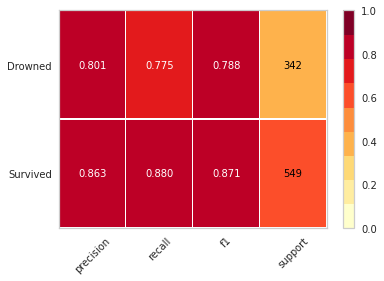

In [ ]:
# Train
log_clf = LogisticRegression(random_state=5).fit(X, Y)
p = log_clf.predict(X)
acc = accuracy_score(Y, p)
vis = ClassificationReport(log_clf,
                            classes=["Drowned","Survived"],
                            support=True)
vis.score(X, Y)
print(f"\n\nLogistic Regression Classification Report \n with accuracy {round(acc,3)}")


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Logistic Regression CV Classification Report 
 with accuracy 0.84


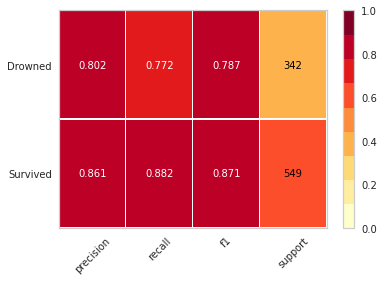

In [ ]:
logCV_clf = LogisticRegressionCV(random_state=10678678).fit(X, Y)
p = logCV_clf.predict(X)
acc = accuracy_score(Y, p)
vis = ClassificationReport(logCV_clf,
                           max_iter = 1000,
                            classes=["Drowned","Survived"],
                            support=True)
vis.score(X, Y)
print(f"\n\nLogistic Regression CV Classification Report \n with accuracy {round(acc,3)}")

In [ ]:
def kfold_cv(X,Y,n_iterations):
  lambdas = np.linspace(0.01,1,100)
  scores = dict()
  for lam in lambdas:
    scores[str(lam)] = []
    for iteration in range(n_iterations):
      X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25)
      tree = xgb.XGBClassifier(n_estimators=20,
                              max_depth=4,
                              objective='reg:squarederror',
                              subsample=0.8,
                              reg_lambda = lam)
      tree.fit(X_train,Y_train)
      p = tree.predict(X_test)
      f1 = f1_score(Y_test, p)
      scores[str(lam)].append(f1)
  return scores

In [ ]:
scores = kfold_cv(X,Y,5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


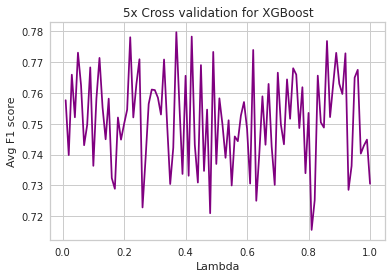

In [ ]:
sns.lineplot([float(key) for key in scores.keys()],[np.mean(val) for val in scores.values()],color='purple')
plt.title('5x Cross validation for XGBoost')
plt.ylabel('Avg F1 score')
plt.xlabel('Lambda')
plt.show()

In [ ]:
# Therefore we should select lambda:
best_lambda = sorted(scores,key=lambda x:np.mean(scores[x]),reverse=True)[0]
print("Best performing Lambda: ", best_lambda)

Best performing Lambda:  0.37




XGBoost Classification Report 
 with accuracy 0.878


/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


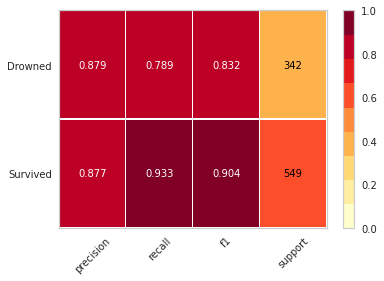

In [ ]:
tree = xgb.XGBClassifier(n_estimators=20,
                         max_depth=4,
                         objective='reg:squarederror',
                         subsample=0.8,
                         reg_lambda = best_lambda)
tree.fit(X,Y)
p = tree.predict(X)
acc = accuracy_score(Y, p)
vis = ClassificationReport(tree,
                           classes=["Drowned","Survived"],
                           support=True)
vis.score(X, Y)
print(f"\n\nXGBoost Classification Report \n with accuracy {round(acc,3)}")

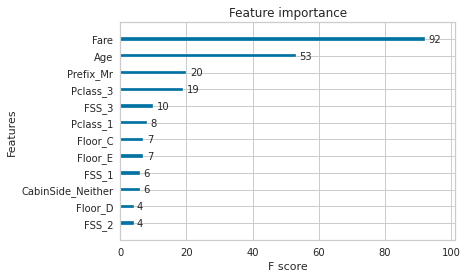

In [ ]:
xgb.plot_importance(tree,max_num_features=12)

# **Final Scores**

In [ ]:
pred = log_clf.predict(X_test)
test = pd.read_csv('test.csv')
test['Survived'] = pred 
p = test[['PassengerId','Survived']]
p.to_csv('logprediction.csv',index=False)

In [ ]:
# Score -   0.76076 

In [ ]:
cv_pred = logCV_clf.predict(X_test)
test = pd.read_csv('test.csv')
test['Survived'] = cv_pred 
p = test[['PassengerId','Survived']]
p.to_csv('logCVprediction.csv',index=False)

In [ ]:
# Score - 0.76076

In [ ]:
tree_pred = tree.predict(X_test)
test = pd.read_csv('test.csv')
test['Survived'] = tree_pred
p = test[['PassengerId','Survived']]
p.to_csv('tree_prediction.csv',index=False)

In [ ]:
# Score - 0.77033

# **Lasso Path**

In [ ]:
a,b,c = lars_path(np.array(X), np.array(Y), method="lasso", verbose=False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:660: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 52 iterations, i.e. alpha=7.521e-04, with an active set of 40 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:660: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 56 iterations, i.e. alpha=5.745e-04, with an active set of 44 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:660: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=4.862e-04, with an active set of 45 regressors, and the smallest cholesky pivot el

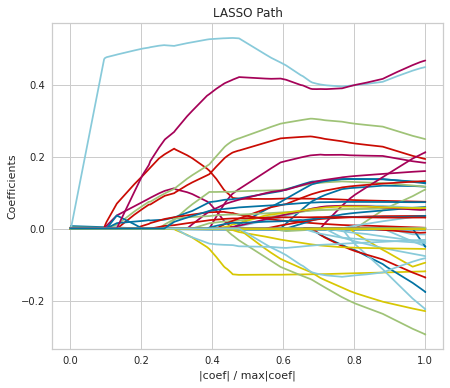

In [ ]:
xx = np.sum(np.abs(c.T), axis=1)
xx /= xx[-1]
f = plt.figure(figsize=(7, 6))
plt.plot(xx, c.T)
ymin, ymax = plt.ylim()
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.show()

In [ ]:
print("25 Most important features: ")
for feature in b[:25]:
  print(X.columns[feature])

25 Most important features: 
Fare
is_female
Pclass_1
SibSp_0
Parch_0
Prefix_Master
SibSp_1
Embarked_C
Age
is_Young Adult
CabinSide_Starborad
Prefix_Mrs
FSS_-2
Pclass_3
CabinSide_Neither
Floor_E
Parch_1
is_Infant
SibSp_2
ticket_MedFare
Floor_D
Embarked_S
FSS_4
ticket_LowFare
FSS_2


In [ ]:
# Let's see if using these features only improves the model:

In [ ]:
important_features = [X.columns[feature] for feature in b[:25]]
X, X_test = X[important_features], X_test[important_features]



XGBoost Classification Report 
 with accuracy 0.877


/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


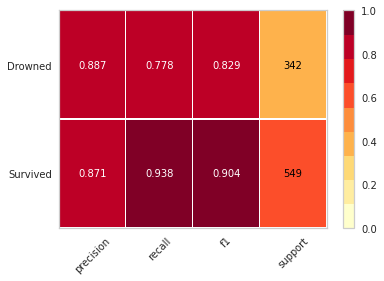

In [ ]:
tree = xgb.XGBClassifier(n_estimators=20,
                         max_depth=4,
                         objective='reg:squarederror',
                         subsample=0.8,
                         reg_lambda = best_lambda)
tree.fit(X,Y)
p = tree.predict(X)
acc = accuracy_score(Y, p)
vis = ClassificationReport(tree,
                           classes=["Drowned","Survived"],
                           support=True)
vis.score(X, Y)
print(f"\n\nXGBoost Classification Report \n with accuracy {round(acc,3)}")

In [ ]:
tree_pred = tree.predict(X_test)
test = pd.read_csv('test.csv')
test['Survived'] = tree_pred
p = test[['PassengerId','Survived']]
p.to_csv('tree_prediction_25_features.csv',index=False)

In [ ]:
# Score -  0.76555
# Not an improvment.

# **Ethereum Useres Dataset**
Each data point is the behavioral distance of two Ethereum users. The behavioral features were determined beforehand. The target of thie exercise it to see wheter users retain their behavior - some of the data points came from the same user (label=1), others didn't. If a classifier can distinguish between the two classes it is a good indicator that users indeed retain their behavior.

In [ ]:
from sklearn.metrics import f1_score
import random

data = pd.read_csv('distanceMatrix.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

# **Overview and Feature extraction**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   avg_outgoing_incoming_ratio  1106 non-null   float64
 1   bin_00_03                    1106 non-null   float64
 2   bin_03_06                    1106 non-null   float64
 3   bin_06_09                    1106 non-null   float64
 4   bin_09_12                    1106 non-null   float64
 5   bin_12_15                    1106 non-null   float64
 6   bin_15_18                    1106 non-null   float64
 7   bin_18_21                    1106 non-null   float64
 8   bin_21_00                    1106 non-null   float64
 9   consecutive_in_tx_score      1106 non-null   float64
 10  consecutive_out_tx_score     1106 non-null   float64
 11  first_outgoing_tx            1106 non-null   float64
 12  first_tx                     1106 non-null   float64
 13  incoming_tx_freq_m

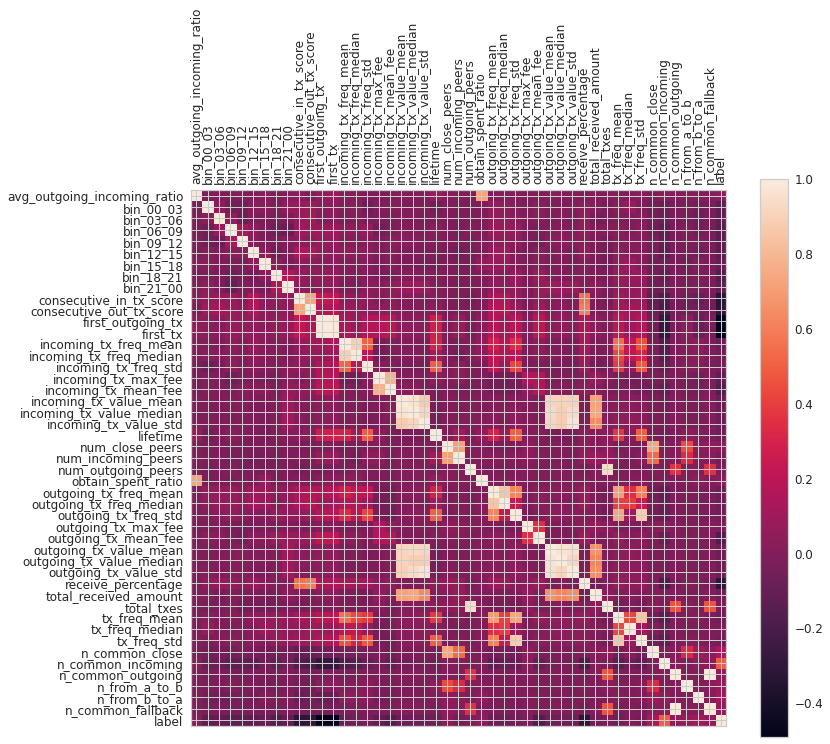

In [ ]:
# Lets use a correlation matrix to gain some insight regarding correlation to label:
f = plt.figure(figsize=(12, 10))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12, rotation=90)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

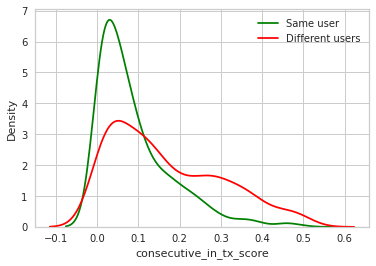

In [ ]:
# Let's explore:
sns.kdeplot(data['consecutive_in_tx_score'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['consecutive_in_tx_score'][data['label'].eq(0)],color='red',label='Different users')
plt.legend()

In [ ]:
# Create a dummy variable:
data['inTxScoreLow'] = [1 if 0 <= x <= 0.1 else 0 for x in data['consecutive_in_tx_score'].values]

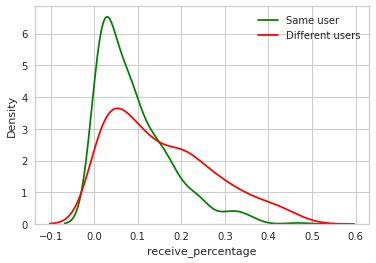

In [ ]:
sns.kdeplot(data['receive_percentage'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['receive_percentage'][data['label'].eq(0)],color='red',label='Different users')
plt.legend()

In [ ]:
# Create a dummy variable:
data['receivePcntLow'] = [1 if 0 <= x <= 0.1 else 0 for x in data['receive_percentage'].values]

In [ ]:
data.pivot_table(index='n_common_incoming',values='label')

,label
n_common_incoming,
0.0,0.258394
1.0,0.978261
2.0,0.928571
3.0,0.931034
4.0,0.913043
5.0,0.750000
6.0,1.000000
7.0,1.000000
11.0,1.000000


In [ ]:
# Create a dummy variable - even 1 in n_common_inc is good:
data['hasCommonInc'] = [1 if 1 <= x  else 0 for x in data['n_common_incoming'].values]

In [ ]:
data.pivot_table(index='n_common_close',values='label')

,label
n_common_close,
0.0,0.500951
1.0,1.000000
2.0,1.000000
3.0,1.000000
10.0,1.000000


In [ ]:
# Im considering dropping this column - it's too strong and might confuse the model.
# data['hasCommonClose'] = [1 if 1 <= x  else 0 for x in data['n_common_close'].values]
data.drop('n_common_close',axis=1,inplace=True)

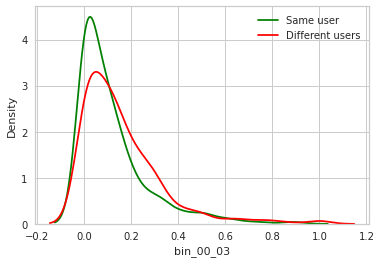

In [ ]:
# Checking Bins:
sns.kdeplot(data['bin_00_03'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['bin_00_03'][data['label'].eq(0)],color='red',label='Different users')
plt.legend()

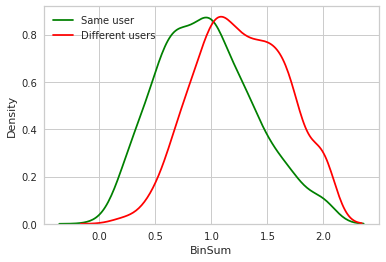

In [ ]:
# Let's try sum over all bins:
data['BinSum'] = data['bin_00_03'] + data['bin_03_06'] + data['bin_06_09'] + data['bin_09_12'] + data['bin_12_15'] + data['bin_15_18'] + data['bin_18_21'] + data['bin_21_00']
sns.kdeplot(data['BinSum'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['BinSum'][data['label'].eq(0)],color='red',label='Different users')
plt.legend()

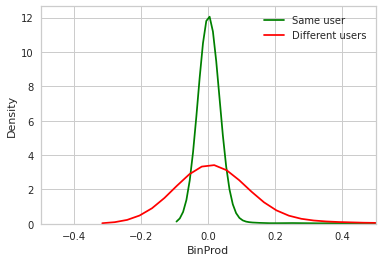

In [ ]:
# Seems Nice! Maybe bin product?
data['BinProd'] = data['bin_00_03'] * data['bin_03_06'] * data['bin_06_09'] * data['bin_09_12'] * data['bin_12_15'] * data['bin_15_18'] * data['bin_18_21'] * data['bin_21_00'] * 10**6
sns.kdeplot(data['BinProd'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['BinProd'][data['label'].eq(0)],color='red',label='Different users')
plt.xlim(-0.5,0.5)
plt.legend()

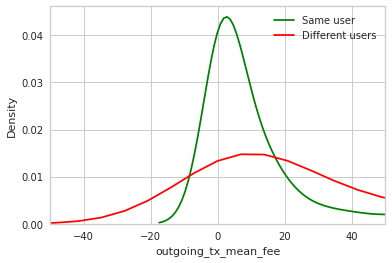

In [ ]:
# Fee:
sns.kdeplot(data['outgoing_tx_mean_fee'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['outgoing_tx_mean_fee'][data['label'].eq(0)],color='red',label='Different users')
plt.xlim(-50,50)
plt.legend()

# **PCA**



Explained variance via PCA:
[0.32292354 0.16473356 0.12587667 0.06482331 0.04575609] 





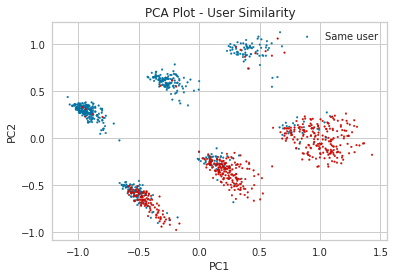

In [ ]:
# Good!
# PCA:
make_pca_plot(data,"User Similarity",ndim=5,scale=True)

In [ ]:
def preprocess_ethereum_data(data, scale=True):
  data.drop('Unnamed: 0',axis=1,inplace=True)
  data['inTxScoreLow'] = [1 if 0 <= x <= 0.1 else 0 for x in data['consecutive_in_tx_score'].values]
  data['receivePcntLow'] = [1 if 0 <= x <= 0.1 else 0 for x in data['receive_percentage'].values]
  data['hasCommonInc'] = [1 if 1 <= x  else 0 for x in data['n_common_incoming'].values]
  data['hasCommonClose'] = [1 if 1 <= x  else 0 for x in data['n_common_close'].values]
  data.drop('n_common_close',axis=1,inplace=True)
  data['BinSum'] = data['bin_00_03'] + data['bin_03_06'] + data['bin_06_09'] + data['bin_09_12'] + data['bin_12_15'] + data['bin_15_18'] + data['bin_18_21'] + data['bin_21_00']
  data['BinProd'] = data['bin_00_03'] * data['bin_03_06'] * data['bin_06_09'] * data['bin_09_12'] * data['bin_12_15'] * data['bin_15_18'] * data['bin_18_21'] * data['bin_21_00'] * 10**6
  X, Y = data.drop('label',axis=1), data['label']
  if scale:
    X = MinMaxScaler().fit_transform(X)
  return X, Y

# **Model Training and Evaluation**

In [ ]:
# Lets fit a classifier.
# Our validation set will be distanceMatrix_test
data = pd.read_csv('distanceMatrix.csv')
print(data.shape)
validation = pd.read_csv('distanceMatrix_test.csv')
for_pca = pd.read_csv('distanceMatrix_test.csv')
print(validation.shape,'\n')
print('Validtion label counts:')
validation.label.value_counts()

(1106, 48)
(1125, 48) 

Validtion label counts:


0    890
1    235
Name: label, dtype: int64

In [ ]:
X,Y = preprocess_ethereum_data(data)
X_validation, Y_validation = preprocess_ethereum_data(validation)



Explained variance via PCA:
[0.30895007 0.11826472 0.11036035 0.07635066 0.04752052] 





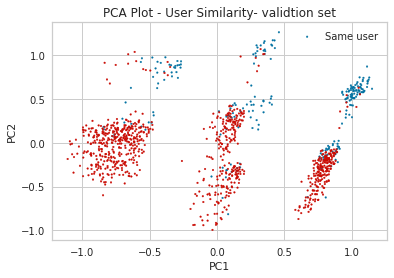

In [ ]:
for_pca_x, y = preprocess_ethereum_data(for_pca, scale=False)
for_pca_x['label'] = y
make_pca_plot(validation,"User Similarity- validtion set",ndim=5,scale=True)

/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,




Logistic Regression Classification Report 
 with accuracy 0.875


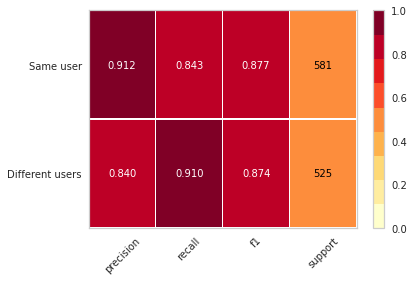

In [ ]:
# Train
log_clf = LogisticRegression(random_state=5).fit(X, Y)
p = log_clf.predict(X)
acc = accuracy_score(Y, p)
vis = ClassificationReport(log_clf,
                            classes=["Same user","Different users"],
                            support=True)
vis.score(X, Y)
print(f"\n\nLogistic Regression Classification Report \n with accuracy {round(acc,3)}")

In [ ]:
pred = log_clf.predict(X_validation)
acc_score = accuracy_score(Y_validation, pred)
f = f1_score(Y_validation, pred)
print("Logitic Regression results on validation set:")
print("Accuracy: ", round(acc_score,3))
print("F1: ", round(f,3) )

Logitic Regression results on validation set:
Accuracy:  0.891
F1:  0.763


In [ ]:
scores = kfold_cv(X,Y,5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


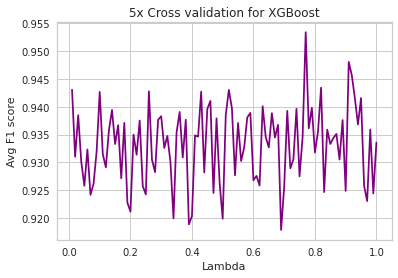

In [ ]:
sns.lineplot([float(key) for key in scores.keys()],[np.mean(val) for val in scores.values()],color='purple')
plt.title('5x Cross validation for XGBoost')
plt.ylabel('Avg F1 score')
plt.xlabel('Lambda')
plt.show()

In [ ]:
best_lambda = sorted(scores,key=lambda x:np.mean(scores[x]),reverse=True)[0]
print("Best performing Lambda: ", best_lambda)

Best performing Lambda:  0.77




XGBoost Classification Report 
 with accuracy 0.97


/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


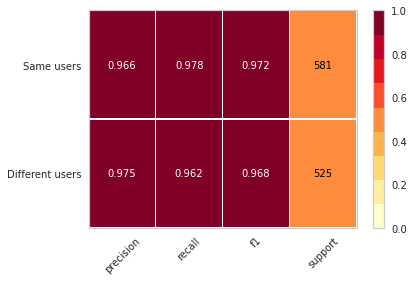

In [ ]:
tree = xgb.XGBClassifier(n_estimators=20,
                         max_depth=4,
                         objective='reg:squarederror',
                         subsample=0.8,
                         reg_lambda = best_lambda)
tree.fit(X,Y)
p = tree.predict(X)
acc = accuracy_score(Y, p)
vis = ClassificationReport(tree,
                           classes=["Same users","Different users"],
                           support=True)
vis.score(X, Y)
print(f"\n\nXGBoost Classification Report \n with accuracy {round(acc,3)}")

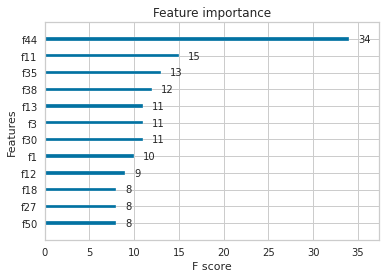

In [ ]:
xgb.plot_importance(tree,max_num_features=12)

In [ ]:
tree_pred = tree.predict(X_validation)
acc_score = accuracy_score(Y_validation, tree_pred)
f = f1_score(Y_validation, tree_pred)
print("XGBoost Regression results on validation set:")
print("Accuracy: ", round(acc_score,3))
print("F1: ", round(f,3) )

XGBoost Regression results on validation set:
Accuracy:  0.856
F1:  0.739


In [ ]:
# Seems like xgboost is overfitting, while logistic regression is doing great.

In [ ]:
a,b,c = lars_path(X_validation, Y_validation, method="lasso", verbose=False)

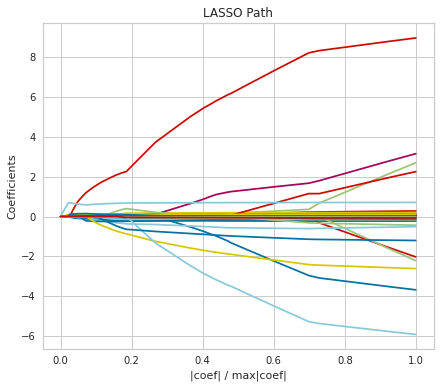

In [ ]:
xx = np.sum(np.abs(c.T), axis=1)
xx /= xx[-1]
f = plt.figure(figsize=(7, 6))
plt.plot(xx, c.T)
ymin, ymax = plt.ylim()
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.show()

In [ ]:
print("10 Most important features: ")
for feature in b[:10]:
  print(for_pca_x.columns[feature])

10 Most important features: 
hasCommonInc
inTxScoreLow
receivePcntLow
first_tx
receive_percentage
n_common_fallback
consecutive_in_tx_score
incoming_tx_mean_fee
num_outgoing_peers
first_outgoing_tx
